# 1) Coleta de Dados IPEA DATA

Os dados do PIB real foram coletados de duas formas, uma via download direto do arquivo excel e outra de uma API que traz os dados mais atualiados.


=> http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38414

## 1.1) Dados Planilha PIB, Consumo, EMBI+

In [1]:
# A planilha está na pasta dados.

import os
import pandas as pd
import math
from tabulate import tabulate
diretorio = os.path.dirname(os.getcwd())
local_arquivo = os.path.join(diretorio,
                             'dados',
                             'Dados.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo)

#As datas dos arquivo ipeadata não são reconhecidos como data pelo python.
#Abaixo crio uma serie de datas trimestrais e a incluo como indice (index) do dataframe pib_pm_deflacionado_ipca
dataframe.index = pd.date_range('1996-03',
                      periods=len(dataframe['PIB  precos de mercado IPCA']),
                      freq='Q')

dataframe['PIB  precos de mercado IPCA'] = [math.log(pib) for pib in dataframe['PIB  precos de mercado IPCA'].values]
dataframe['PIB  consumo final  familias  IPCA'] = [math.log(pib) for pib in dataframe['PIB  consumo final  familias  IPCA'].values]


#selecionando a coluna PIB a preços de marcado deflacionado pelo IPCA
pib_pm_deflacionado_ipca = dataframe['PIB  precos de mercado IPCA']
consumo_deflacionado_ipca = dataframe['PIB  consumo final  familias  IPCA']
embi_media = dataframe['EMBI Média']
embi_fim_periodo = dataframe['EMBI Fim de Período']

## 1.2) Dados Planilha Juros Americanos

In [2]:
# A planilha de juros está na pasta dados.

local_arquivo_juros = os.path.join(diretorio,
                             'dados',
                             'Taxa de Juros Americanos Trimestre.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo_juros)

#As datas dos arquivo ipeadata não são reconhecidos como data pelo python.
#Abaixo crio uma serie de datas trimestrais e a incluo como indice (index) do dataframe juro_americanos
dataframe.index = pd.date_range('1962-01',
                      periods=len(dataframe['DGS10 media']),
                      freq='Q')

#selecionando a coluna PIB a preços de marcado deflacionado pelo IPCA
taxa_juros_americanos_media = dataframe['DGS10 media']
taxa_juros_americanos_fim_periodo = dataframe['DGS10 fim periodo']



# 2) Dessazonalizar Série

Abaixo coloquei a documentação do ajuste de sazonalidade x13
https://www.statsmodels.org/stable/generated/statsmodels.tsa.x13.x13_arima_analysis.html

In [23]:
# Pacote statsmodels que possui o x13
import statsmodels.tsa as sm

#precisei baixar um arquivo do site census pra poder a ajuste ser feito
#abaixo esta o site e o stackoverflow tirando duvidas sobre como fazer funcionar o ajuste no pyhton
#https://www.census.gov/srd/www/x13as/
#https://stackoverflow.com/questions/32053770/arima-seasonal-prediction-with-python-x12a-and-x13as-not-found-on-path

#coloquei o aquivo no numa pasta chamada x13 dentro do diretorio do notebook
local_x13_seassonal_file = os.path.join(diretorio,
                                        'notebook',
                                        'x13',
                                        'x13as')

#execução do ajuste
pib_pm_deflacionado_ipca_dessazonalizado = sm.x13.x13_arima_analysis(pib_pm_deflacionado_ipca,x12path=local_x13_seassonal_file)
consumo_deflacionado_ipca_dessazonalizado = sm.x13.x13_arima_analysis(consumo_deflacionado_ipca,x12path=local_x13_seassonal_file)



dataframe_pib_pm_deflacionado_ipca_dessazonalizado = pd.DataFrame(pib_pm_deflacionado_ipca_dessazonalizado.seasadj)
dataframe_pib_pm_deflacionado_ipca_dessazonalizado = dataframe_pib_pm_deflacionado_ipca_dessazonalizado.rename(columns={'seasadj':'PIB Real Dessazonalizado'})
dataframe_consumo_deflacionado_ipca_dessazonalizado = pd.DataFrame(consumo_deflacionado_ipca_dessazonalizado.seasadj)
dataframe_consumo_deflacionado_ipca_dessazonalizado = dataframe_consumo_deflacionado_ipca_dessazonalizado.rename(columns={'seasadj':'Consumo Real Dessazonalizado'})

#Descomente para printar o ajuste
#pib_pm_deflacionado_ipca_dessazonalizado.seasadj



# Exportando os Dados de log do PIB e CONSUMO dessazonalizado para Excel
Tabela_Dessazonalizada = pd.concat([dataframe_pib_pm_deflacionado_ipca_dessazonalizado,
                                    dataframe_consumo_deflacionado_ipca_dessazonalizado], axis=1, sort=False)

#Tabela_Dessazonalizada.to_excel('Tabela_Dessazonalizada.xls')

## 2.1) Plot das Series

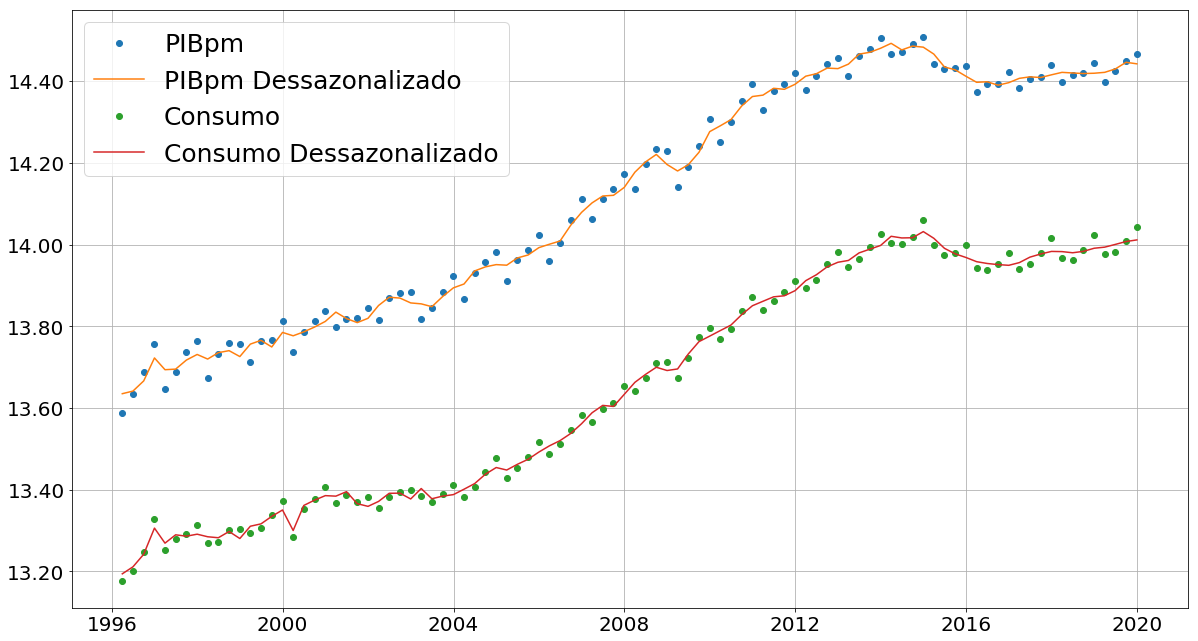

In [24]:
#pacotes de gráficos
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot da Serie original
ax.plot(pib_pm_deflacionado_ipca.index,
        pib_pm_deflacionado_ipca.values,'o',label='PIBpm')

# Plot da Serie Com Ajuste Sazonal
ax.yaxis.set_major_formatter(tick) 
ax.plot(pib_pm_deflacionado_ipca_dessazonalizado.seasadj.index,
        pib_pm_deflacionado_ipca_dessazonalizado.seasadj.values,label='PIBpm Dessazonalizado')

# Plot da Serie original Consumo
ax.plot(consumo_deflacionado_ipca.index,
        consumo_deflacionado_ipca.values,'o',label='Consumo')

# Plot da Serie Com Ajuste Sazonal Consump
ax.yaxis.set_major_formatter(tick) 
ax.plot(consumo_deflacionado_ipca_dessazonalizado.seasadj.index,
        consumo_deflacionado_ipca_dessazonalizado.seasadj.values,label='Consumo Dessazonalizado')



# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",fontsize=25)


# 3) Aplicando Filtros  

## 3.1) Band Pass - Baxter and King
https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_filters.html

No call que fizemos eu nao me lembrava onde tinha visto sobre esse filtro. 
https://www.researchgate.net/publication/24111493_Measuring_Business_Cycles_The_Real_Business_Cycle_Approach_and_Related_Controversies

Quando comecei o a rodar os modelos em 2016 eu ja conhecia esse filtro, mas se não me engano na época eu perdia parte inicial e final da amostra. Mas tinha compreendido errado o que é calibração. Se entendi bem a ideia desses tipos de modelos DSGE é replicar o primeiro e o segundo momento o mais proximo da realidade da amostra.


Site com explicações do pacote
https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.bk_filter.bkfilter.html

In [25]:
# Pacode de Display de tabela em HTML
from IPython.core.display import display, HTML
#Pacote com o filtro Baxter King => sm.filters.bk_filter.bkfilter()
# pib_pm_deflacionado_ipca_dessazonalizado.seasadj é o resultado do ajuste x13
# seasadj chama os objeto com as datas e os valores
# low = O período mínimo para oscilações. Baxter e King sugerem que o ciclo de negócios calculados por Burns-Mitchell nos EUA tenha 6 para dados trimestrais e 1,5 para dados anuais.
# high = Período máximo para oscilações BK sugere que o ciclo de negócios nos EUA tenha 32 para dados trimestrais e 8 para dados anuais.
pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk = sm.filters.bk_filter.bkfilter(pib_pm_deflacionado_ipca_dessazonalizado.seasadj,
                                                                                     low=6,
                                                                                     high=32,
                                                                                     K=12)
consumo_deflacionado_ipca_dessazonalizado_filtrado_bk = sm.filters.bk_filter.bkfilter(consumo_deflacionado_ipca_dessazonalizado.seasadj,
                                                                                     low=6,
                                                                                     high=32,
                                                                                     K=12)



# o retorno é um vetor [array] com os componetes ciclicos serie x. Descomente a linhade baixo para printar
df_pib_filtrado = pd.DataFrame(pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk)
# Dando nome a coluna de datas
df_pib_filtrado.index.name = "Data"
# transformando a tabela em HTML 
pib_filtrado_tabela_HTML = tabulate(df_pib_filtrado, tablefmt="html")
# descomente para printar a tabela
#display(HTML(pib_filtrado_tabela_HTML))

## 3.2) Christiano Fitzgerald asymmetric, random walk filter.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.cf_filter.cffilter.html#statsmodels.tsa.filters.cf_filter.cffilter

O filtro Christiano-Fitzgerald é uma generalização de BK e, portanto, também pode ser visto como média móvel ponderada.

os parametros low e high seguem as mesmas especificações do filtro BK

o parametro drift é a tendência dos dados. A tendência é estimada como np.arange (nobs) * (x [-1] - x [0]) / (len (x) -1).

In [26]:
# Com drift
pib_cf_filter_cycle_cf_drift, pib_cf_filter_trend_cf_drift = sm.filters.cf_filter.cffilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'],
                                           low=6,
                                           high=32,
                                           drift=True)

# Sem drift
pib_cf_filter_cycle_cf_drift_s, pib_cf_filter_trend_cf_drift_s = sm.filters.cf_filter.cffilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'],
                                           low=6,
                                           high=32,
                                           drift=False)


# Com drift
consumo_cf_filter_cycle_cf_drift, consumo_cf_filter_trend_cf_drift = sm.filters.cf_filter.cffilter(dataframe_consumo_deflacionado_ipca_dessazonalizado['seasadj'],
                                           low=6,
                                           high=32,
                                           drift=True)

# Sem drift
consumo_cf_filter_cycle_cf_drift_s, consumo_cf_filter_trend_cf_drift_s = sm.filters.cf_filter.cffilter(dataframe_consumo_deflacionado_ipca_dessazonalizado['seasadj'],
                                           low=6,
                                           high=32,
                                           drift=False)

## 3.3) HP simples

In [27]:
pib_hp_filter_cycle, pib_hp_filter_trend = sm.filters.hp_filter.hpfilter(dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'],
                                                                               1600)

consumo_hp_filter_cycle, consumo_hp_filter_trend = sm.filters.hp_filter.hpfilter(dataframe_consumo_deflacionado_ipca_dessazonalizado['seasadj'],
                                                                               1600)

## 3.4) Primeira Diferença (É assim?)

Vi que tem e especificação desse modelo no Arquivo do Pfeifer, mas nao li com detelhe e assumi que o filtro primeira diferença fosse somente a amostra atual menos a mostra defasada t-1.

In [28]:
pib_deflacionado_primeira_diferenca = dataframe_pib_pm_deflacionado_ipca_dessazonalizado['seasadj'].diff()

consumo_deflacionado_primeira_diferenca = dataframe_consumo_deflacionado_ipca_dessazonalizado['seasadj'].diff()

# Plot do componente Ciclico do PIB Real Dessazonalizado 1996:T1-2016:T4

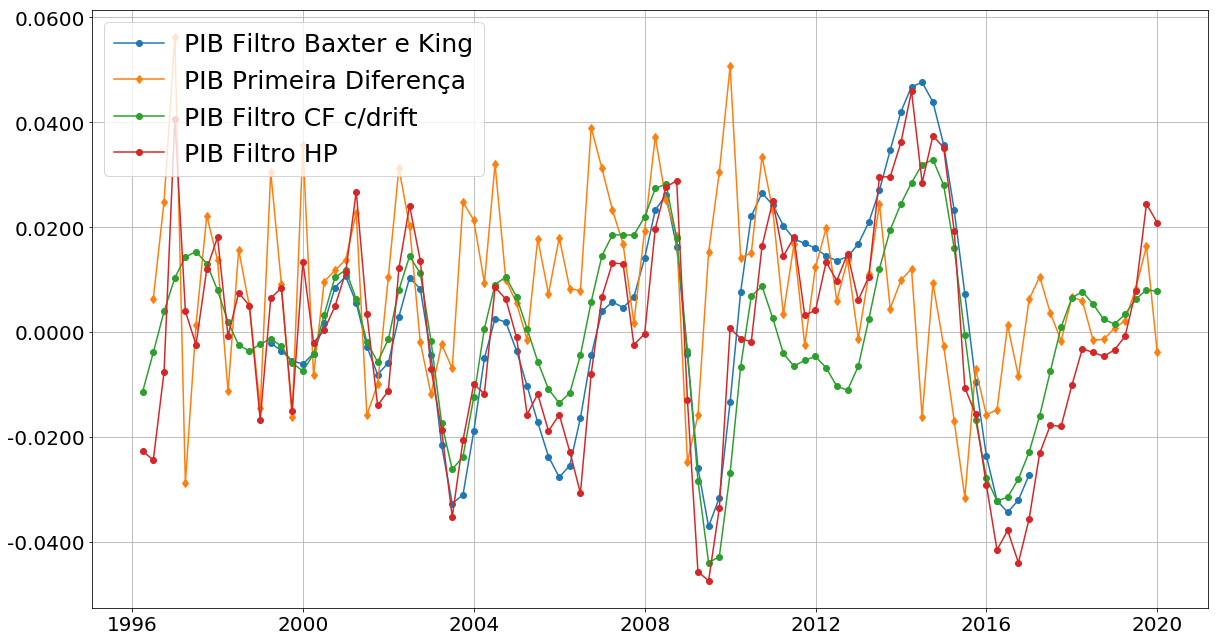

In [29]:
fmt = '{x:,.4f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk.index,
        pib_pm_deflacionado_ipca_dessazonalizado_filtrado_bk.values,
        '-o',
        label='PIB Filtro Baxter e King')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(pib_deflacionado_primeira_diferenca.index,
        pib_deflacionado_primeira_diferenca.values,
        '-d',
        label='PIB Primeira Diferença')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald asymmetric, random walk filter.
ax.plot(pib_cf_filter_cycle_cf_drift.index,
        pib_cf_filter_cycle_cf_drift.values,
        '-o',
        label='PIB Filtro CF c/drift')



# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald sem drift
#ax.plot(pib_cf_filter_cycle_cf_drift_s.index,
#        pib_cf_filter_cycle_cf_drift_s.values,
#        '-o',
#        label='PIB Filtro CF s/drift')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro HP.
ax.plot(pib_hp_filter_cycle.index,
        pib_hp_filter_cycle.values,
        '-o',
        label='PIB Filtro HP')


# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Plot do componente Ciclico do PIB Real Dessazonalizado 1996:T1-2016:T4

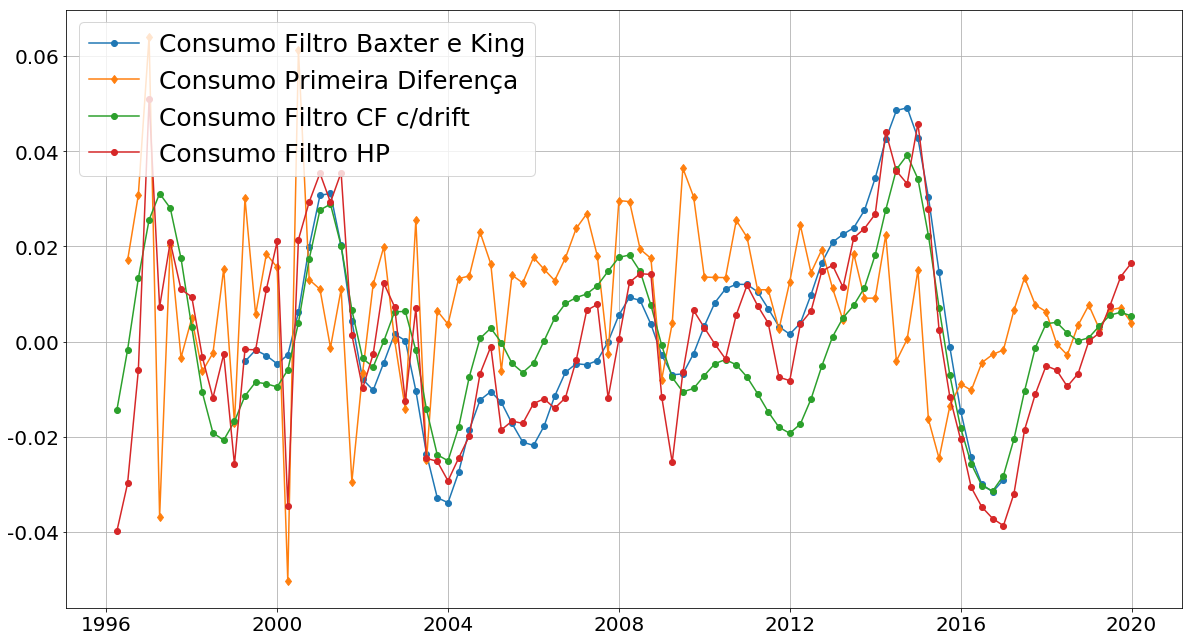

In [31]:
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(consumo_deflacionado_ipca_dessazonalizado_filtrado_bk.index,
        consumo_deflacionado_ipca_dessazonalizado_filtrado_bk.values,
        '-o',
        label='Consumo Filtro Baxter e King')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(consumo_deflacionado_primeira_diferenca.index,
        consumo_deflacionado_primeira_diferenca.values,
        '-d',
        label='Consumo Primeira Diferença')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald asymmetric, random walk filter.
ax.plot(consumo_cf_filter_cycle_cf_drift.index,
        consumo_cf_filter_cycle_cf_drift.values,
        '-o',
        label='Consumo Filtro CF c/drift')



# Plot do Compenente ciclico da série do pib real dessazonalizado filtro Christiano Fitzgerald sem drift
#ax.plot(pib_cf_filter_cycle_cf_drift_s.index,
#        pib_cf_filter_cycle_cf_drift_s.values,
#        '-o',
#        label='PIB Filtro CF s/drift')

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro HP.
ax.plot(consumo_hp_filter_cycle.index,
        consumo_hp_filter_cycle.values,
        '-o',
        label='Consumo Filtro HP')


# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Plot EMBI+ Trimestral, Média e Fim do Periodo

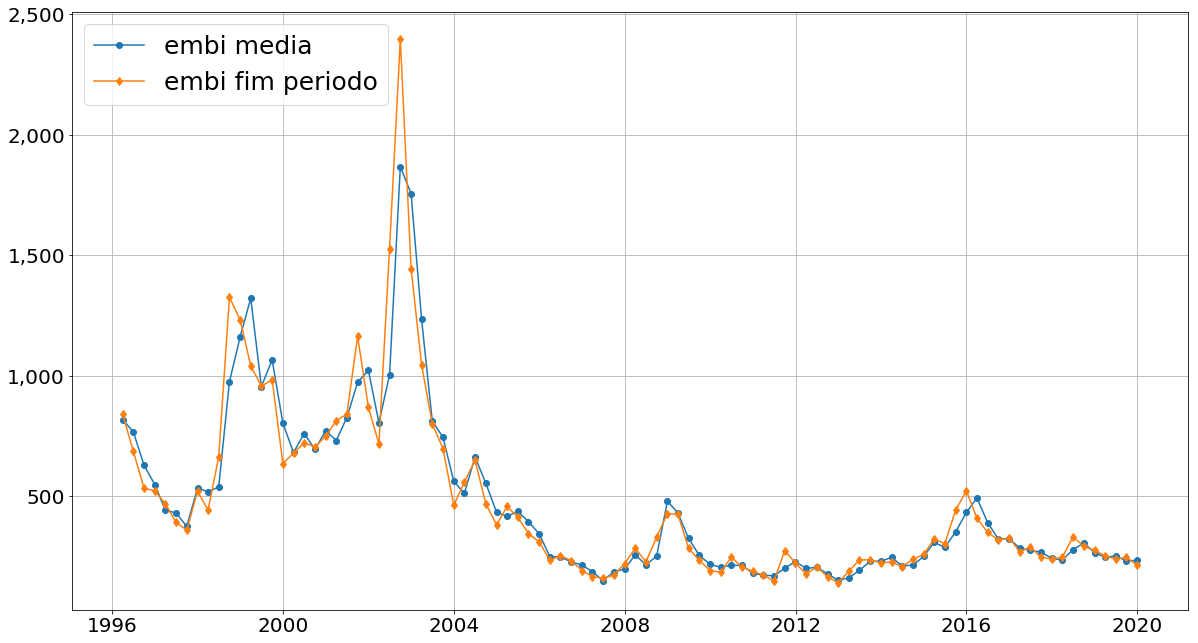

In [32]:
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(embi_media.index,
        embi_media.values,
        '-o',
        label='embi media')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(embi_fim_periodo.index,
        embi_fim_periodo.values,
        '-d',
        label='embi fim periodo')



# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

# Plot Juros Americanos 10 Anos Trimestral, Média e Fim do Periodo

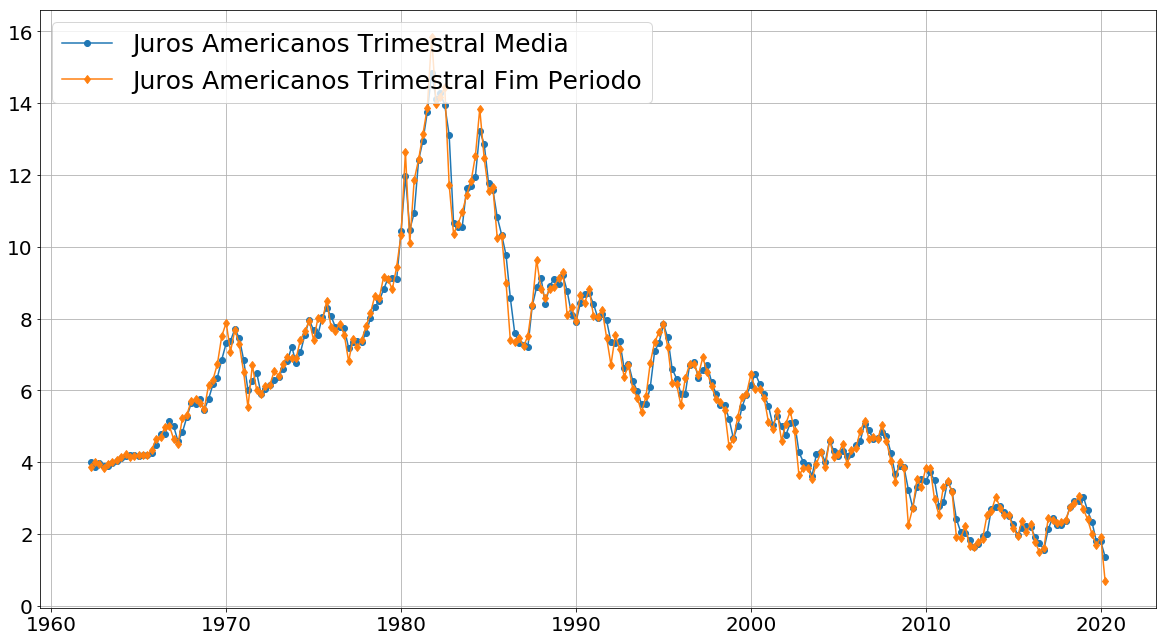

In [33]:
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Plot do Compenente ciclico da série do pib real dessazonalizado filtro BK
ax.yaxis.set_major_formatter(tick) 
ax.plot(taxa_juros_americanos_media.index,
        taxa_juros_americanos_media.values,
        '-o',
        label='Juros Americanos Trimestral Media')

# Plot da Primeira diferenaça da serie do pib dessazonalizado (isso é um filtro primeira diferença?)
ax.plot(taxa_juros_americanos_fim_periodo.index,
        taxa_juros_americanos_fim_periodo.values,
        '-d',
        label='Juros Americanos Trimestral Fim Periodo')



# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legndas
ax.legend(loc="upper left",
          fontsize=25)

In [73]:
taxa_juros_americanos_media.describe()

count    233.000000
mean       6.099574
std        2.905826
min        1.365000
25%        4.016290
50%        5.889841
75%        7.732188
max       14.838437
Name: DGS10 media, dtype: float64

In [74]:
taxa_juros_americanos_fim_periodo.describe()

count    233.000000
mean       6.081974
std        2.947893
min        0.700000
25%        3.960000
50%        5.810000
75%        7.680000
max       15.840000
Name: DGS10 fim periodo, dtype: float64